In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pylops
import math
import pyproximal
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator
from pylops import LinearOperator as PyLinearOperator
from pylops.basicoperators import FunctionOperator
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.optimize import minimize
# from sklearn import datasets
from scipy.stats import multivariate_normal, norm

In [3]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape


def objective_1D(z, y, A, G, w=1, lmbda = 0):
    '''
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    
    input

        w - option to put in more variation like Tikhonov?

    '''
    # to do implement size checks for A, z, G
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    # evaluations of G
    xc = G.eval(zc)
    Dx = G.jac(zc)

    # evaluations of A
    yp = A.eval(xc)
    Dy = A.jac(xc)

    # compute value and gradient least squares
    #val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2 # change to 1 norm??
    gradc   = Dx.H(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

    return val, grad

def generate_noise(m, sigma, noise_type="spread", num_localized=None, seed=None):
    """
    Generate noise with the same norm for both spread out and localized noise, ensuring reproducibility with a seed.

    Parameters:
    - m             = int, number of measurements
    - sigma         = float, noise standard deviation
    - noise_type    = str, either "spread" or "localized"
    - num_localized = int, number of entries to have noise (only for "localized" type)
    - seed          = int, optional random seed for reproducibility

    Returns:
    - noise         = np.ndarray, noise vector of shape (m,)
    """
    if seed is not None:
        np.random.seed(seed) # generate local seed

    # generate spread noise
    spread_noise = sigma * np.random.randn(m)
    spread_norm = np.linalg.norm(spread_noise)

    if noise_type == "spread":
        return spread_noise  
    
    elif noise_type == "localized":
        if num_localized is None:
            num_localized = max(1, m // 4)  #default: 25% of entries affected
        
        noise = np.zeros(m)
        #indices = np.random.choice(m, num_localized, replace=False)  # select noise locations randomly
        index = np.random.randint(0,m-(num_localized-1), dtype=int) # select random first index for noise
        localized_noise = sigma * np.random.randn(num_localized)  # generate localized noise gaussian

        # normalize to match spread-out noise norm
        localized_norm = np.linalg.norm(localized_noise)
        if localized_norm > 0:
            localized_noise *= spread_norm / localized_norm  # scale noise to match spread norm entrywise

        noise[index:(index+num_localized)] = localized_noise # add noise to correct entries
        return noise
    
    else:
        raise ValueError("Invalid noise_type. Choose 'spread' or 'localized'.")

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0, noise_type = "spread", num_localized=None, seed=None):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    noise = generate_noise(m, sigma, noise_type, num_localized, seed=seed)
    yobs  = A.eval(xtrue) + noise

    # inference
    result = minimize(objective_1D, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # extract complex values
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, zhat

In [94]:
class CompNonlinearL2(pyproximal.Nonlinear):
    def setup(self, A, G, y, alpha=1.0): #alpha and niter still need to check
        self.A = A  # forward operator
        self.G = G  # generative model
        self.y = y  # (noisy) measurements
        self.alpha = alpha  # step size gradient descent optimisation

    def fun(self, x):
        l  = len(x)//2
        xc = x[:l] + 1j*x[l:]
        return 0.5*np.linalg.norm(self.A.eval(self.G.eval(xc)) - self.y)**2

    def grad(self, x):
        l  = len(x)//2
        xc = x[:l] + 1j*x[l:]
        residual = self.A.eval(self.G.eval(xc)) - self.y
        gradc =(self.G.jac(xc).H) @ (self.A.jac(self.G.eval(xc)).H) @ residual 
        grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
        return grad

    def optimize(self):
        '''gradient descent optimisation'''
        self.solhist = []
        sol = self.x0.copy()
        for _ in range(self.niter):  
            grad = self._gradprox(sol, self.tau)  # compute prox-gradient
            sol -= self.alpha * grad  # gradient descent step
            self.solhist.append(sol)
        self.solhist = np.array(self.solhist)
        return sol 

def reconstruct_fista(xtrue, A, G, w=1, sigma=0, lmbda=0.001, maxit = 2000, noise_type = "spread", num_localized=None, seed=None, tau=None):
    '''
    Minimises LS objective
        0.5*\|A(G(z)) - y\|_2^2 + lmbda*\|z\|_1
    using fast iterative soft thresholding algorithm. 

    Input:
    - xtrue         = complex np.ndarray, true signal
    - A             = operator from Op class
    - G             = operator from Op class
    - w             = np.ndarray, currently not implemented (additional regularisation)
    - sigma         = float, variance of gaussian noise
    - lmbda         = float, parameter controlling the amount of regularisation, cannot be set to 0
    - maxit         = int, maximal number of iterations of fista
    - noise_type    = string, type of gaussion noise added to observations
    - num_localized = int, number of entries local noise is added to
    - seed          = int, ensures reproducability of noise experiments
    
    Output:
    - error         = float, 2-norm normalized difference true signal and approximation
    - xhat          = complex np.ndarray, approximation to xtrue
    - zhat          = complex np.ndarray, output of fista
    
    '''
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    noise = generate_noise(m, sigma, noise_type, num_localized, seed=seed)
    yobs  = A.eval(xtrue) + noise

    # set up proximal operators
    startguess = np.ones(2*k)
    l1 = pyproximal.proximal.L1(sigma=w)
    l2 = CompNonlinearL2(niter=50, x0=startguess, warm=True) # combined approach means x = (x1, x2)
    l2.setup(A, G, yobs, alpha=0.001) 

    # fista # try just guessing for tau instead of backtracking
    zhat = \
    pyproximal.optimization.primal.ProximalGradient(l2, l1, tau=tau, x0=startguess,
                                                    epsg=lmbda, niter=maxit, acceleration='fista', show=False) # add complex initial guess + try splitting complex and imaginary part in optimisation 

    # extract values
    zc   = zhat[:k] + 1j*zhat[k:]
    xhat = G.eval(zc)
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)

    # return
    return error, xhat_corr, zc, startguess

In [5]:
def MaskedFourier_1D(M):
    '''
    Masked 1D fourier transform as a linear operator.

    input:
        M - 2D array of size n x m containing m windows of length n
    
    output:
        A - linear operator representing the masked Fourier transforms

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    mv  = lambda x : fft(M*x[:, None], axis=0).flatten()
    rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()
    
    A = LinearOperator((nx*mx, nx), matvec=mv, rmatvec = rmv)

    return A

def block_signal(length,starts,heights,widths):
    '''
    input:
        lentgh signal, start (integer index), height, width (integer ndices)
    '''
    nsamples = len(starts)
    signals = np.zeros((nsamples, length))

    for i in range(nsamples):
        start = int(starts[i])
        width = int(widths[i])
        height = heights[i]
        end = min(start + width, length-10)  # Ensure block stays within bounds
        signals[i, start:end] = height
        
    return signals

def cut_off_lowpass(data, highcut):
    data = np.atleast_2d(data)
    n = data.shape[1] # will not go well if X is higher dim
    k = fftfreq(n,1)
    cut_off = np.where((k < -highcut ) | (k > highcut))[0]
    
    data_fft = fft(data)
    data_fft[:,cut_off] = 0
    new_data = np.real(ifft(data_fft, axis=1)) # also only works for real data
    return (new_data, cut_off) if data.shape[0] > 1 else (new_data[0], cut_off)

def sine_signal(n, frequencies):
    '''
    input: grid length, frequencies (nsamples x 3), time
    '''
    nsamples = frequencies.shape[0]
    t = np.linspace(0, 1, n, False)  # 1 second

    signals = np.zeros((nsamples,n))
    for i in range(nsamples):
        signals[i] = np.sin(2*np.pi*frequencies[i,0]*t) + np.sin(2*np.pi*frequencies[i,1]*t) + np.sin(2*np.pi*frequencies[i,2]*t)
        norm = la.norm(signals[i])
        signals[i] = signals[i]/norm
    
    return signals

# 1D ambiguity function
def Ambiguity(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - signal of length L
        m - shift of the signal
    output:
        Fourier vector of the signal multiplied by its conjugate shift
    '''
    shift_phi = np.conjugate(np.roll(phi,m))
    return fft(phi*shift_phi)

def ambiguityconst(windows):
    '''
    input:
        windows     window functions (length, number of windows/measurements)
    '''
    mx = len(windows[0,:])
    c = 0
    for i in range(2):
        for j in range(mx): 
            mask_test = Ambiguity(windows[:,j], i)
            temp_max = 1/abs(mask_test).min() #potential hazard of dividing by small numbers
            if temp_max > c:
                c = temp_max
                remember_mask_index = j
    return c, remember_mask_index

# compute stability constant
def stabilityconst(n, x, delta, c):
    '''
    input:
        n       signal gridsize
        x       signal set, specified as (number of samples, length of sample)
        delta   threshold
        c       ambiguity function threshold   
    output:
        constant bound for reconstruction
    '''
    max_norm = np.max(np.linalg.norm(x, axis = 1)) # along rows
    C = c/delta*(1 + np.sqrt(2*n*max_norm)/delta)
    return C

In [100]:
# define experiment
def run_experiment(Xtrue, A, G, sigmas):
    nsigmas = len(sigmas)
    k       = G.shape[1]
    Xhat    = np.zeros((n,nsamples,nsigmas),dtype=complex)
    errors  = np.zeros((nsamples,nsigmas))
    zhat    = np.zeros((k,nsamples,nsigmas),dtype=complex)
    
    for i in range(nsamples):
        for j in range(nsigmas):
             errors[i,j], Xhat[:,i,j], zhat[:,i,j] = reconstruct(Xtrue[i,:], A, G, sigma = sigmas[j])
    
    return Xhat, errors, zhat

def plot_experiment(Xhat, errors, Xtrue, sigmas):
    nsigmas = len(sigmas)
    
    fig,ax  = plt.subplots(nsigmas,5,sharey=True)

    for j in range(nsigmas):
        for i in range(5):
            ax[j,i].plot(domain,Xtrue[i,:],'k--')
            ax[j,i].plot(domain,np.real(Xhat[:,i,j]),'r')
            ax[j,i].set_ylim([0,1])
            ax[j,i].set_aspect(1)

    fig.tight_layout()
    plt.show()
    print('sigma    | error (std)')
    for j in range(nsigmas):
        print('%1.2e | %1.2e (%1.2e)'%(sigmas[j],np.mean(errors[:,j]),np.std(errors[:,j])))


def artefact_experiment(ztrue, etas, A, G, H, w, sigmas, lmbda, localization=1, maxit = 2000, seed=None, tau=None): # consider scrapping lmbda and setting to 1e1*sigmas[i] 
    '''
    Localization is percentage
    Shouldn't we get size from the operators instead of global variable assumption?
    Has to be combined approach (need both G and H)
    '''
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    _, nsamples = ztrue.shape
    nsigmas     = len(sigmas)
    netas       = len(etas)
    Xhat        = np.zeros((n,nsamples,nsigmas,netas),dtype=complex)
    errors      = np.zeros((nsamples,nsigmas,netas))
    zhat        = np.zeros((k,nsamples,nsigmas,netas),dtype=complex)
    Gbias       = np.zeros((nsamples,nsigmas,netas))

    if seed is not None:
        np.random.seed(seed) # generate local seed
    
    artfact = np.zeros((n, nsamples))
    indices = math.ceil(n*localization/100) # number of indices artefact is localized on
    for i in range(nsamples):
        start_index = np.random.randint(0, n - indices)
        artfact[start_index:start_index + indices,i] = np.random.standard_normal(indices) * etas[i]

    Xtrue = G.eval(ztrue) + artfact  

    for i in range(nsamples):
        for j in range(nsigmas):
             for l in range(netas):
                errors[i,j,l], Xhat[:,i,j,l], zhatcombined,_ = reconstruct_fista(Xtrue[:,i], A, H, w = w, sigma=sigmas[j], lmbda=lmbda, maxit=maxit, tau=tau)
                zhat[:,i,j,l] = zhatcombined[:k]
                Gbias[i,j,l] = np.linalg.norm(G.eval(zhat[:,i,j,l]) - Xhat[:,i,j,l], ord=1)
    
    return Xhat, errors, zhat, Gbias, Xtrue

def plot_artefact(Gbias, etas, sigmas, errors, plot = "artefact"):
    '''
    plot can be artefact or (measurement) noise
    '''
    nsamples = Gbias.shape[0]
    nsigmas = len(sigmas)
    netas   = len(etas)
    
    if plot == "artefact":
        fig,ax  = plt.subplots(nsigmas,nsamples,sharey=True)

        for i in range(nsamples):
            for j in range(nsigmas):
                ax[j,i].plot(etas,Gbias[i,j,:])
                #ax[j,i].set_ylim([0,1]) 
                ax[j,i].set_aspect(1)

        fig.tight_layout()
        plt.show()

        print('artefact | bias (std)')
        for l in range(netas):
            for j in range(nsigmas):
                print(f'sigma = {sigmas[j]}')
                print('%1.2e | %1.2e (%1.2e)'%(etas[l],np.mean(Gbias[:,j,l]),np.std(Gbias[:,j,l])))

    elif plot == "noise":
        fig,ax  = plt.subplots(netas,nsamples,sharey=True)

        for i in range(nsamples):
            for l in range(netas):
                ax[l,i].plot(sigmas,Gbias[i,:,l])
                #ax[l,i].set_ylim([0,1])
                ax[l,i].set_aspect(1)

        fig.tight_layout()
        plt.show()
    
    else:
        raise ValueError("Invalid plot option. Choose 'artefact' or 'noise'.")


In [7]:
# parameters
delta    = 0.3 # threshold
nsamples = 1  # number of samples to generate for validation
n        = 100  # grid size for signal
mx       = 50 # number of measurements
bandwidth = .25 # relative bandwidth for generative model \in (0,1]
k        = 50 # input length generative model
#sigmas   = [1e-3, 1e-2, 1e-1, 1e3] # noise levels to use for validation

# grid
domain   = np.linspace(0,1,n)

(1, 100)
0.17469821712354575


TypeError: 'Axes' object is not subscriptable

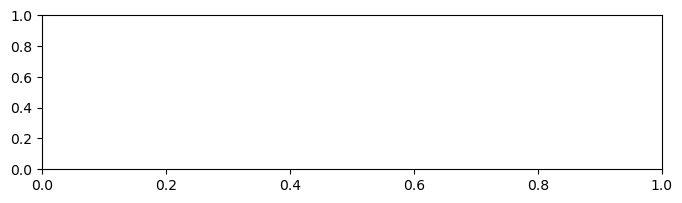

In [8]:
# (low freq sines) create data set 
frequencies = np.random.randint(2,50, size=(nsamples,3))

Xlowfreq = sine_signal(n,frequencies)
print(Xlowfreq.shape)
smallest = np.abs(np.min(Xlowfreq))
print(smallest)
#print(np.min(Xtrue), np.max(Xtrue))

Xlowfreq = Xlowfreq + smallest

fig,ax = plt.subplots(1,nsamples, figsize=(8, 2))
#fig,ax = plt.subplots(1,5)

for i in range(nsamples):
    ax[i].plot(domain,Xlowfreq[i,:])
    #ax[i].set(aspect='equal')
    ax[i].set_box_aspect(1)

fig.tight_layout()
plt.show()

# make complex phase retrieval set
Xlowfreq_complex = 0.01*np.ones((nsamples,n)) + 1j*Xlowfreq

smallest = np.min(np.abs(Xlowfreq_complex))
print(smallest)
print(np.max(np.abs(Xlowfreq_complex)))

print(smallest**2)
print(1/n)

(5, 100)


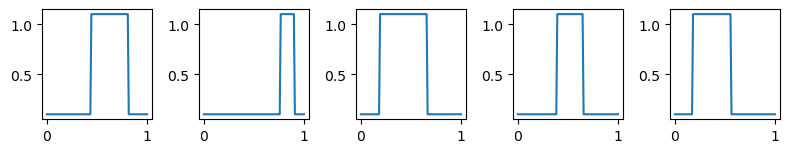

In [ ]:
# (blocks) create data set of a block signal with threshold delta bounded away from 0
heights  = np.ones(nsamples)
starts   = np.random.randint(10,n-20,nsamples)
widths   = np.random.randint(5,n/2,nsamples)

Xblock = block_signal(n,starts,heights,widths) + delta
print(Xblock.shape)

fig,ax = plt.subplots(1,nsamples, figsize=(8, 2))

for i in range(5):
    ax[i].plot(domain,Xblock[i,:])
    #ax[i].set_aspect(1)
    ax[i].set_box_aspect(1)

fig.tight_layout()
plt.show()

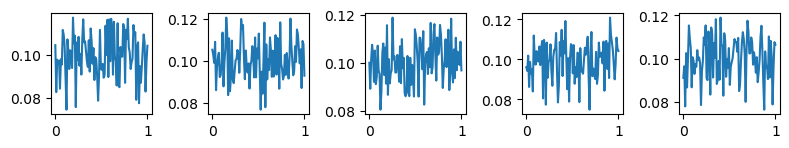

In [ ]:
# (random) dataset
Xrandom = np.random.normal(0,1/n,size=(nsamples,n)) + delta

fig,ax = plt.subplots(1,nsamples, figsize=(8, 2))

for i in range(5):
    ax[i].plot(domain,Xrandom[i,:])
    ax[i].set_box_aspect(1)

fig.tight_layout()
plt.show()

The value of c is 574.003902659291
Lowest threshold of the ambiguity function is 0.0017421484337774016
The mask with the lowest ambiguity threshold is 35


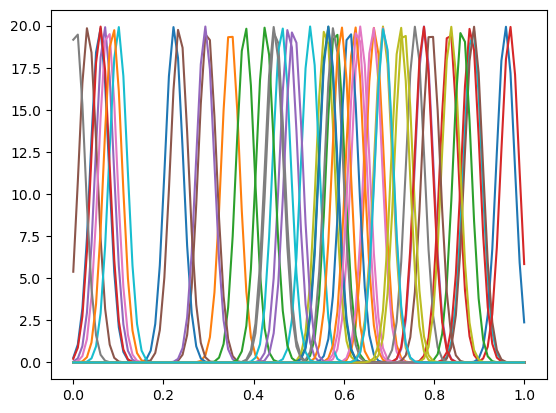

In [9]:
# describes mx window functions of length n, use gaussian windows
windows = np.zeros((n,mx))
mu      = np.random.uniform(0,1,mx)
windows = norm.pdf(domain[:, np.newaxis], mu, .02) # do not use a high variance, leads to small values ambiguity function

# make into n x n x mx matrix
M = np.zeros((n,n,mx))
for i in range(mx):
    M[:,:,i] = np.diag(windows[:,i])

# calculate threshold value of the ambiguity
c, mask_index = ambiguityconst(windows)
print("The value of c is", c)
print("Lowest threshold of the ambiguity function is", 1/c)
print("The mask with the lowest ambiguity threshold is", mask_index)

fig, ax = plt.subplots()
ax.plot(domain,windows)
plt.show()

In [10]:
# define operators
m    = mx * n
MF   = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))
A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

# bandwidth G
# freq   = fftfreq(n)
# S      = np.eye(n)[:,np.abs(freq)<=bandwidth/1.1]
# k      = S.shape[1]
# Gfun   = lambda z : threshold_value + ifft(S@z)
# Gjac   = lambda p : LinearOperator((n,k), matvec = lambda z : ifft(S@z), rmatvec = lambda x : (S.T@fft(x))/n)
# G      = Op(fun = Gfun, jac = Gjac, shape=(n,k))

# matrix G
rng = np.random.default_rng(99)
GM    = rng.normal(0,1/n,size=(n,k))
Gsing = np.linalg.svd(GM, full_matrices=False, compute_uv=False, hermitian=False)
while Gsing[-1] < 1e-4: # check for small singular values
    GM  = np.random.normal(0,10/n,size=(n,k))
    Gsing = np.linalg.svd(GM, full_matrices=False, compute_uv=False, hermitian=False)
Gfun  = lambda z : delta + GM@z
Gjac  = lambda p : LinearOperator((n,k), matvec = lambda z : GM@z, rmatvec = lambda x : np.conj(GM.T)@x)
G     = Op(fun = Gfun, jac = Gjac, shape=(n,k))

# identity operator
I     = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

# combined generative model
C     = np.concatenate((GM, np.eye(n)), axis=1)
Hjac  = lambda p : LinearOperator((n,k+n), matvec = lambda z : C@z, rmatvec = lambda x : np.conj(C.T)@x)
H     = Op(fun = lambda z : delta + C@z, jac = Hjac, shape=(n,k+n))

# weights
#w     = 1

# both currently not used
# composition A(G(x))
CompAGfun = lambda x : A.eval(G.eval(x))
CompAGjac = lambda x : LinearOperator((m, k), matvec=lambda z : A.jac(G.eval(x))@G.jac(x)@z, rmatvec = lambda z : (G.jac(x).H)@(A.jac(G.eval(x)).H)@z)
CompAG    = Op(fun = CompAGfun, jac = CompAGjac, shape=(m,k))

# composition A(H(x))
CompAHfun = lambda x : A.eval(H.eval(x))
CompAHjac = lambda x : LinearOperator((m,k+n), matvec = lambda z : A.jac(H.eval(x))@H.jac(x)@z, rmatvec = lambda z : (H.jac(x).H)@(A.jac(H.eval(x)).H)@z) 
CompAH    = Op(fun = CompAHfun, jac = CompAHjac, shape=(m,k+n))

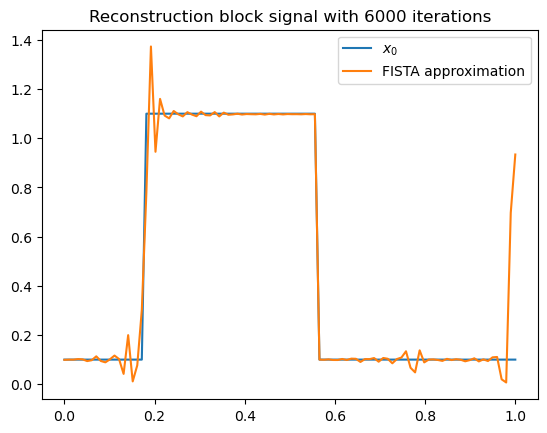

In [17]:
# test fista (later integrate into reconstruction function)
xtrue = Xblock[np.random.randint(0,Xlowfreq.shape[0])]

maxiter = 6000
noise_var = 0.01
error_test, xhat_test, zhat_test = reconstruct_fista(xtrue, A, I, w=0, sigma=0, lmbda=0.001, maxit=maxiter, seed=42)

# plt.figure()
# plt.plot(domain, xtrue, label=r'$x_0$')
# plt.plot(domain, np.real(H.eval(x_fista)), label = 'FISTA approximation')
# plt.legend()
# plt.show()

plt.figure()
plt.plot(domain, xtrue, label=r'$x_0$')
plt.plot(domain, np.real(xhat_test), label = 'FISTA approximation')
plt.title(f"Reconstruction block signal with {maxiter} iterations")
plt.legend()
plt.show()

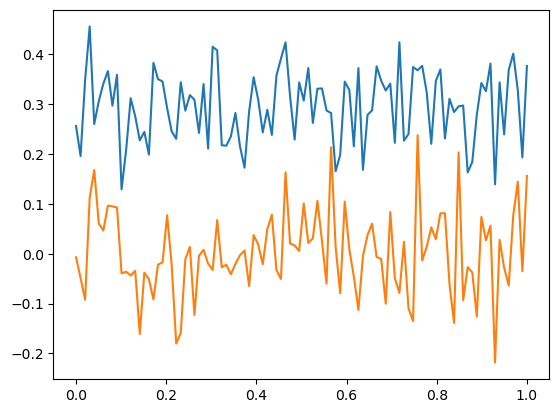

In [11]:
# for random input, this is the kind of signal the model generates
z = np.random.randn(k) + 1j*np.random.randn(k)
plt.figure()
plt.plot(domain, np.real(G.eval(z)))
plt.plot(domain, np.imag(G.eval(z)))
plt.show()


### Testing in quality of reconstruction for various noise levels

In [82]:
Xhat1, errors1, zhat1 = run_experiment(Xlowfreq, A, I, sigmas)

In [83]:
Xhat2, errors2, _ = run_experiment(Xlowfreq, A, G, sigmas)

In [84]:
Xhat3, errors3, _ = run_experiment(Xlowfreq, A, H, sigmas)

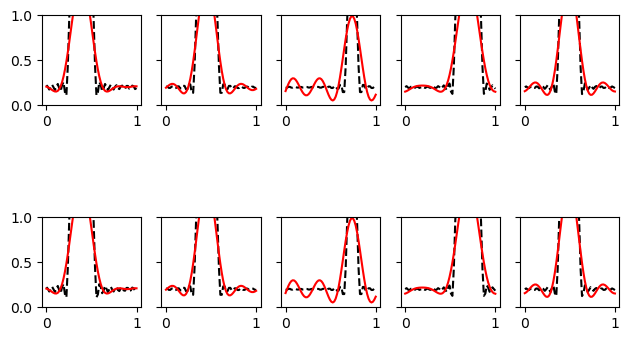

sigma    | error (std)
0.00e+00 | 2.57e-01 (6.04e-02)
0.00e+00 | 2.57e-01 (6.04e-02)


In [82]:
plot_experiment(Xhat_test, errors_test, X_filtered, [0, 0])

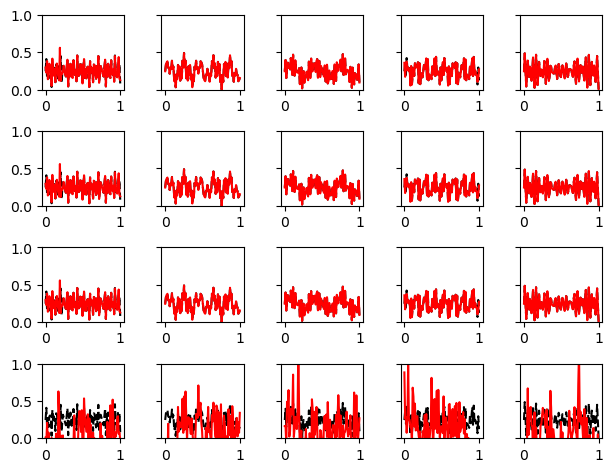

sigma    | error (std)
1.00e-03 | 8.94e-02 (1.05e-01)
1.00e-02 | 8.65e-02 (1.06e-01)
1.00e-01 | 8.42e-02 (1.08e-01)
1.00e+03 | 1.71e+00 (1.16e-01)


In [85]:
plot_experiment(Xhat1, errors1, Xlowfreq, sigmas)
#plot_experiment(np.imag(Xhat1), errors1, np.imag(Xcomplex), sigmas)

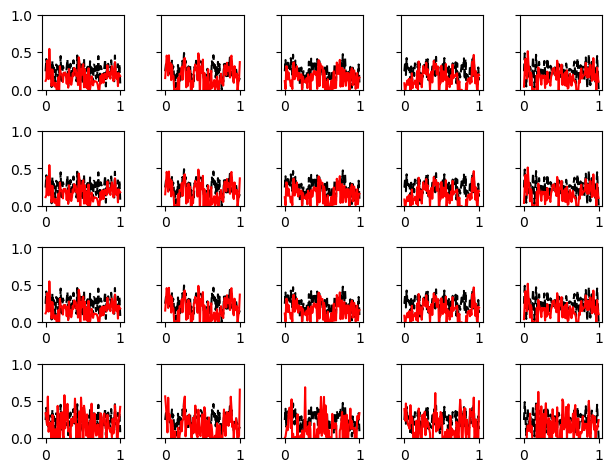

sigma    | error (std)
1.00e-03 | 9.81e-01 (3.40e-02)
1.00e-02 | 9.81e-01 (3.40e-02)
1.00e-01 | 9.81e-01 (3.40e-02)
1.00e+03 | 1.36e+00 (9.40e-02)


In [86]:
plot_experiment(Xhat2, errors2, Xlowfreq, sigmas) 
#plot_experiment(np.imag(Xhat2), errors2, np.imag(Xcomplex), sigmas) 

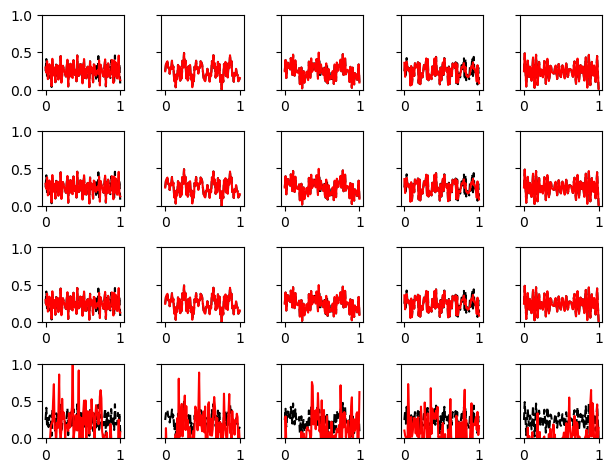

sigma    | error (std)
1.00e-03 | 1.56e-01 (1.32e-01)
1.00e-02 | 1.63e-01 (1.26e-01)
1.00e-01 | 1.63e-01 (1.25e-01)
1.00e+03 | 1.71e+00 (1.16e-01)


In [87]:
plot_experiment(Xhat3, errors3, Xlowfreq, sigmas) 

### Graph of noise levels vs reconstruction error

In [55]:
# scan over noise levels combined approach generative model on in or out-distribution gt, with different noise types
ns           = 3 # times to repeat the experiment
sigmas       = np.logspace(-6,6,10)
num_loc      = np.array([m // 5, m // 50, m // 500]) # number of entries the measurement noise is localized on

# spread noise
errors_s = np.zeros((len(sigmas),ns))
#bias_s   = np.zeros((len(sigmas),ns))
xhats_s  = np.zeros((len(sigmas),ns, n),dtype='complex')

# localized noise
errors_l = np.zeros((len(sigmas),ns, len(num_loc)))
#bias_l   = np.zeros((len(sigmas),ns, len(num_loc)))
xhats_l  = np.zeros((len(sigmas),ns, n, len(num_loc)),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        #xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k)) #here xtrue comes from the generative model
        xtrue = Xlowfreq[np.random.randint(0,Xlowfreq.shape[0])] # from the dataset
               
        errors_s[i,j], xhats_s[i,j,:], zhat_temp = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i], noise_type = "spread", seed=42)
        #zhat2_s[i,j,:] = zhat_temp[-n:]
        #G_zhat_temp = xhats_s[i,j,:] - zhat2_s[i,j,:]
        #phi = np.mean(np.angle(xtrue/G_zhat_temp))
        #G_zhat_s = np.exp(1j*phi)*G_zhat_temp
        #bias_s[i,j] = np.linalg.norm(G_zhat_s - xtrue)/np.linalg.norm(xtrue)

        for p in range(len(num_loc)):
            errors_l[i,j,p], xhats_l[i,j,:,p], zhat_temp = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i], noise_type = "localized", num_localized=num_loc[p], seed=42)
            #zhat2_l[i,j,:] = zhat_temp[-n:]
            # G_zhat_temp = xhats_l[i,j,:] - zhat2_l[i,j,:]
            # phi = np.mean(np.angle(xtrue/G_zhat_temp))
            # G_zhat_l = np.exp(1j*phi)*G_zhat_temp
            # bias_l[i,j] = np.linalg.norm(G_zhat_l - xtrue)/np.linalg.norm(xtrue)

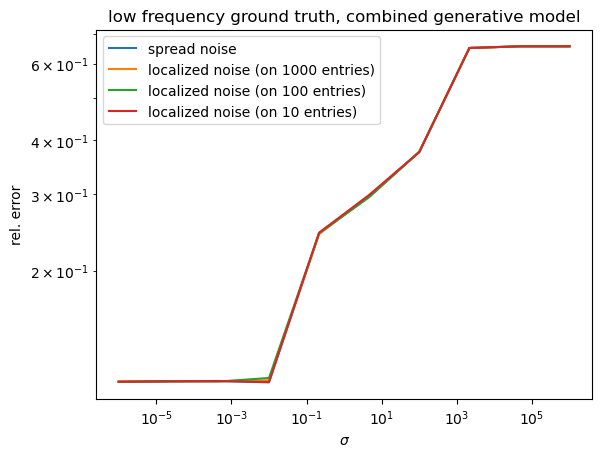

In [56]:
fig, ax = plt.subplots(1)

# spread
ax.loglog(sigmas, np.mean(errors_s,axis=1), label='spread noise')

# localized
ax.loglog(sigmas, np.mean(errors_l[:,:,0],axis=1), label='localized noise (on %d entries)'%num_loc[0])
ax.loglog(sigmas, np.mean(errors_l[:,:,1],axis=1), label='localized noise (on %d entries)'%num_loc[1])
ax.loglog(sigmas, np.mean(errors_l[:,:,2],axis=1), label='localized noise (on %d entries)'%num_loc[2])

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('low frequency ground truth, combined generative model')
ax.legend()

#### Artefact reconstruction experiment

In [106]:
# function set-up
z = np.random.randn(k)+1j*np.random.randn(k)
z = z[:, None]
eta = [0.2] # variation of the noise
sigma = [0.2]
artefact_loc = 5 # amount of localization: has to between 1 and 100, percentage of entries signal with artefact noise
artefact_seed = 21 # reproducability

Xhat, errors, zhat, Gbias, Xartefact = artefact_experiment(z, eta , A, G, H, w=1, sigmas=sigma, lmbda=1e1*sigma[0], localization=5, maxit=10000, seed=artefact_seed, tau=1e-8)

print(Gbias.shape)
print(np.linalg.norm(eta,1))
print(Gbias[0,0,0])
print(Xartefact.shape)

(1, 1, 1)
0.2
11.28619081024252
(100, 1)


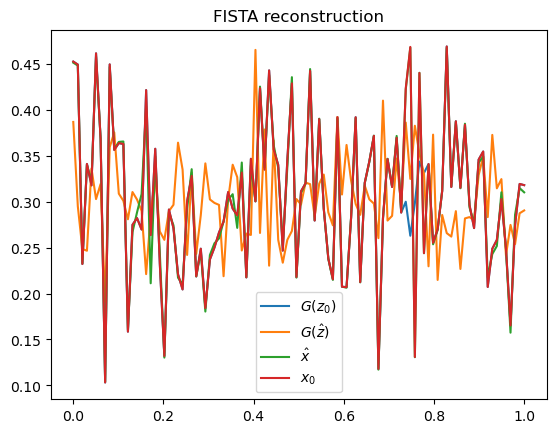

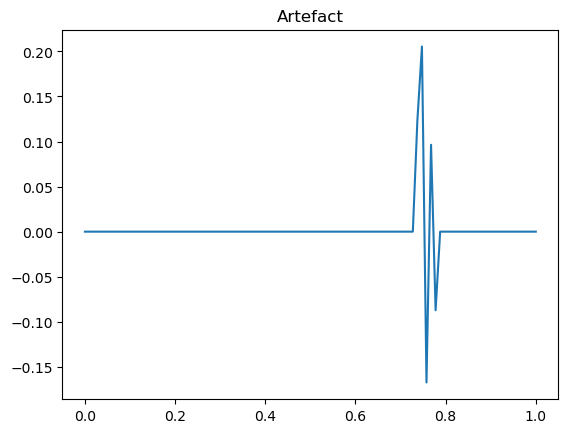

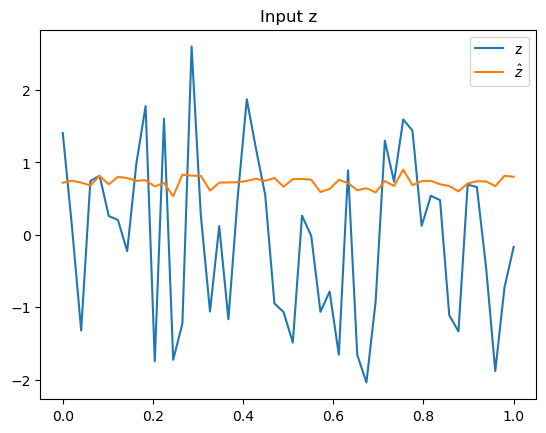

In [107]:
plt.figure()
plt.plot(domain, np.real(G.eval(z)), label=r'$G(z_0)$')
plt.plot(domain, np.real(G.eval(zhat[:,0,0,0])), label=r'$G(\hat{z})$')
plt.plot(domain, np.real(Xhat[:,0,0,0]), label=r'$\hat{x}$')
plt.plot(domain, np.real(Xartefact), label=r'$x_0$')
plt.title("FISTA reconstruction")
plt.legend()
plt.show()

plt.figure()
plt.plot(domain, np.real(Xartefact)-np.real(G.eval(z)))
plt.title("Artefact")
plt.show()

plt.figure()
plt.plot(np.linspace(0,1,k), np.imag(z), label='z')
plt.plot(np.linspace(0,1,k), np.imag(zhat[:,0,0,0]), label=r'$\hat{z}$')
plt.legend()
plt.title("Input z")
plt.show()

In [77]:
# out of function visualisation (test: later delete)
error_fista, xhat_fista, zhat_comb, z_init = reconstruct_fista(Xartefact[:,0], A, H, w=1, sigma=0, lmbda=0.1, maxit=50000, seed=21, tau=1e-8)
zhat_fista = zhat_comb[:k]
print(z_init.shape)
l = z_init.shape[0] // 2
zc_init = z_init[:l] + 1j*z_init[l:]
zc_init = zc_init[:k]
print(zc_init.shape)

(300,)
(50,)


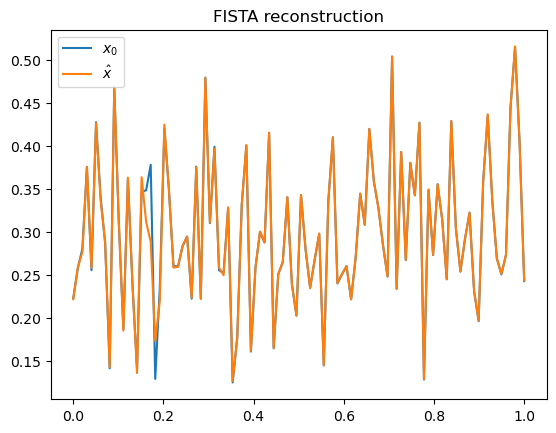

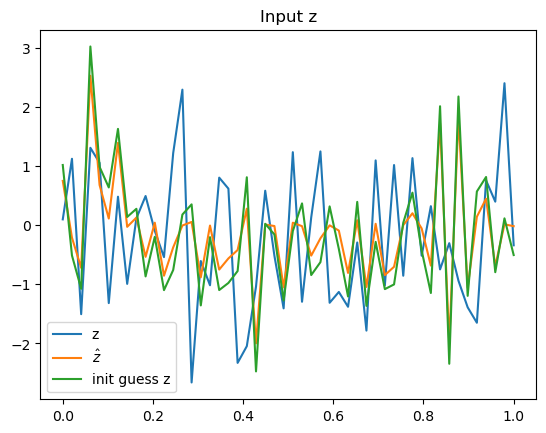

In [78]:
plt.figure()
#plt.plot(domain, np.real(G.eval(z)), label=r'$G(z_0)$')
#plt.plot(domain, np.real(G.eval(zhat_fista)), label=r'$G(\hat{z})$')
plt.plot(domain, np.real(Xartefact), label=r'$x_0$')
plt.plot(domain, np.real(xhat_fista), label=r'$\hat{x}$')
plt.title("FISTA reconstruction")
plt.legend()
plt.show()

plt.figure()
plt.plot(np.linspace(0,1,k), np.real(z), label='z')
plt.plot(np.linspace(0,1,k), np.real(zhat_fista), label=r'$\hat{z}$')
plt.plot(np.linspace(0,1,k), np.real(zc_init), label='init guess z')
plt.legend()
plt.title("Input z")
plt.show()